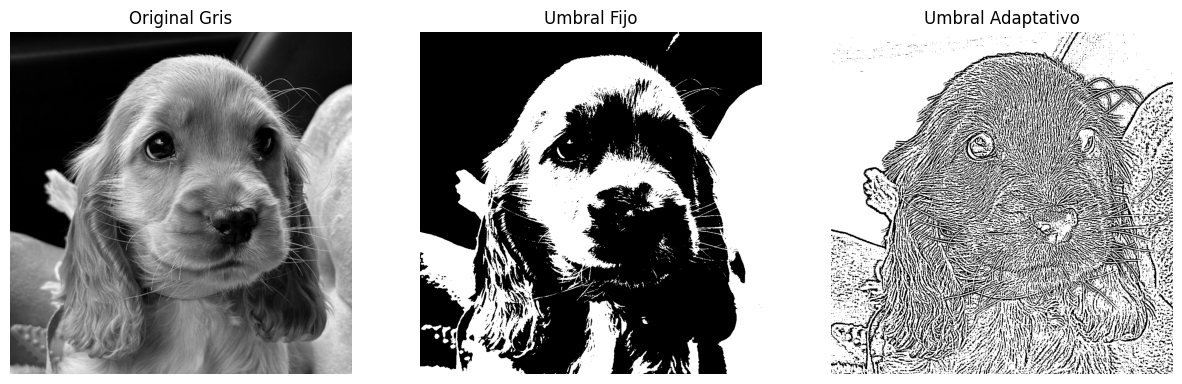

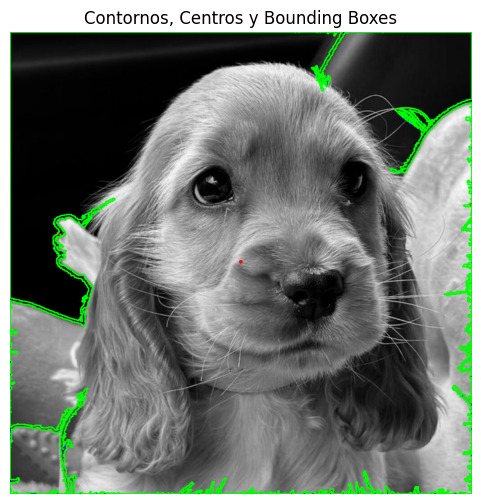

Formas detectadas: 47
Área promedio: 21875.0
Perímetro promedio: 271.5963104456029
--- Fin procesamiento estático ---
Presiona q para salir de la ventana de webcam


KeyboardInterrupt: 

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


def procesar_imagen(estatico=True):
    # Ruta de la imagen HK relativa al script
    script_dir = os.getcwd()
    ruta_imagen = os.path.join(script_dir, '..', 'Capturas', 'HKC.jpg')
    gris = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    if gris is None:
        print(f"Error cargando la imagen en {ruta_imagen}")
        return

    # Umbral fijo
    _, bin_fijo = cv2.threshold(gris, 127, 255, cv2.THRESH_BINARY)
    # Umbral adaptativo
    bin_adap = cv2.adaptiveThreshold(
        gris, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Mostrar imágenes en gris, fijo y adaptativo
    fig, ejes = plt.subplots(1, 3, figsize=(15, 5))
    mapas = [(gris, 'Original Gris'), (bin_fijo, 'Umbral Fijo'), (bin_adap, 'Umbral Adaptativo')]
    for ax, (img, titulo) in zip(ejes, mapas):
        ax.imshow(img, cmap='gray')
        ax.set_title(titulo)
        ax.axis('off')
    plt.show()

    # Detectar contornos en la imagen binarizada adaptativa
    contornos, _ = cv2.findContours(bin_adap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Convertir gris a color para dibujar
    resultado = cv2.cvtColor(gris, cv2.COLOR_GRAY2BGR)

    areas = []
    perimetros = []
    for c in contornos:
        # Centro de masa
        M = cv2.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            cv2.circle(resultado, (cx, cy), 4, (0, 0, 255), -1)
        # Bounding box
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(resultado, (x, y), (x + w, y + h), (255, 0, 0), 2)
        # Métricas de área y perímetro
        areas.append(cv2.contourArea(c))
        perimetros.append(cv2.arcLength(c, True))

    # Dibujar todos los contornos
    cv2.drawContours(resultado, contornos, -1, (0, 255, 0), 2)
    # Mostrar resultado con contornos, centros y cajas
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(resultado, cv2.COLOR_BGR2RGB))
    plt.title('Contornos, Centros y Bounding Boxes')
    plt.axis('off')
    plt.show()

    # Imprimir métricas
    print('Formas detectadas:', len(contornos))
    if areas:
        print('Área promedio:', np.mean(areas))
    if perimetros:
        print('Perímetro promedio:', np.mean(perimetros))
    print('--- Fin procesamiento estático ---')

    # Procesamiento de secuencia (webcam)
    if not estatico:
        captura = cv2.VideoCapture(0)
        if not captura.isOpened():
            print('No se pudo abrir la cámara')
            return
        print('Presiona q para salir de la ventana de webcam')
        while True:
            ok, frame = captura.read()
            if not ok:
                break
            gris_cam = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            thr_cam = cv2.adaptiveThreshold(
                gris_cam, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                cv2.THRESH_BINARY, 11, 2
            )
            cont_cam, _ = cv2.findContours(thr_cam, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cc in cont_cam:
                xx, yy, ww, hh = cv2.boundingRect(cc)
                cv2.rectangle(frame, (xx, yy), (xx + ww, yy + hh), (0, 255, 255), 2)
            cv2.imshow('Webcam - Segmentación', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        captura.release()
        cv2.destroyAllWindows()


if __name__ == '__main__':
    entrada = input("Seleccione modo [0=imagen estática, 1=cámara]: ")
    try:
        modo = int(entrada)
        if modo not in (0, 1):
            raise ValueError
    except ValueError:
        print("Modo inválido, usando imagen estática.")
        modo = 0
    procesar_imagen(estatico=(modo == 0))
